In [90]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")
from sklearn.model_selection import train_test_split

In [91]:
n_per_cluster = 1_000
img_size = 91

x = np.linspace(-4, 4, img_size)
X, Y = np.meshgrid(x, x)

g_widths = np.linspace(2, 20, n_per_cluster)

images = torch.zeros(n_per_cluster, 1, img_size, img_size)
occ_images = torch.zeros(n_per_cluster, 1, img_size, img_size)

In [92]:
for i in range(n_per_cluster):
    random_offset = 2*np.random.randn(2)
    gaussian = np.exp(-((X-random_offset[0])**2 + (Y-random_offset[1])**2) / (2*g_widths[i]**2))
    # adding noise
    gaussian = gaussian + np.random.randn(img_size, img_size) / 5
    images[i,:,:,:] = torch.Tensor(gaussian).reshape(1, img_size, img_size)
    loc = np.random.choice(np.arange(2, 28))
    wid = np.random.choice(np.arange(2, 6))
    if np.random.randn()>0:
        gaussian[loc:loc+wid,:] = 1
    else:
        gaussian[:,loc:loc+wid] = 1
    occ_images[i,:,:,:] = torch.Tensor(gaussian).reshape(1, img_size, img_size)

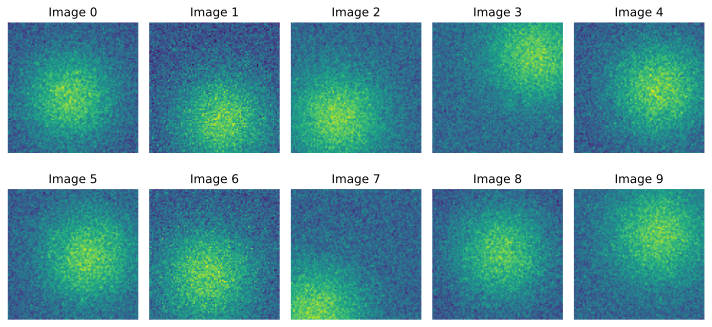

In [128]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(images[i, :, :, :].view(img_size, img_size, 1))
    ax.set_title(f"Image {i}")
    ax.axis("off")
plt.tight_layout()
plt.show()

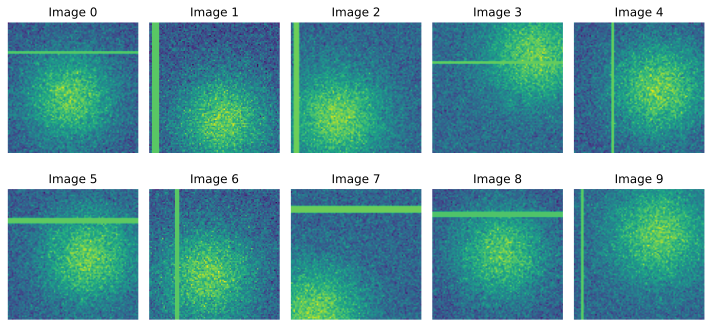

In [122]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(occ_images[i, :, :, :].view(img_size, img_size, 1))
    ax.set_title(f"Image {i}")
    ax.axis("off")
plt.tight_layout()
plt.show()

In [94]:
def create_model():
    class GauseAE(nn.Module):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.enc = nn.Sequential(
                nn.Conv2d(1, 6, 3, 1, 1), # (91 + 2*1 - 3)/1 + 1
                nn.ReLU(),
                nn.MaxPool2d(2), # 91 // 2 = 45
                nn.Conv2d(6, 4, 3, 1, 1), # (45 + 2*1 - 3)/1 + 1
                nn.ReLU(),
                nn.MaxPool2d(2), # 45 // 2 = 2
            )
            self.dec = nn.Sequential(
                nn.ConvTranspose2d(4, 6, 3, 2),
                nn.ReLU(),
                nn.ConvTranspose2d(6, 1, 3, 2)
            )
        def forward(self, x):
            return self.dec(self.enc(x))
    net = GauseAE()
    lossfunc = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=.01)
    return net, lossfunc, optimizer

In [95]:
net, _, _ = create_model()
y = net(torch.randn(5, 1, 91, 91))
y.shape

torch.Size([5, 1, 91, 91])

In [96]:
def train_model():
    net, lossfunc, optimizer = create_model()
    epochs = 50
    batch_size = 16
    losses = []
    for ei in range(epochs):
        batch_loss = []
        net.train()
        for i in range(images.shape[0]//batch_size):
            x = images[i*batch_size:(i+1)*batch_size]
            y = net(x)
            loss = lossfunc(y, x)
            batch_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(np.mean(batch_loss).item())
    return losses, net

        


In [97]:
losses, net = train_model()

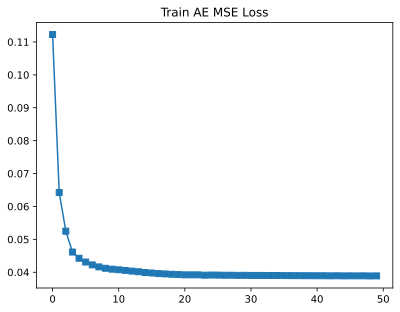

In [98]:
plt.plot(losses, 's-')
plt.title("Train AE MSE Loss")
plt.show()

In [99]:
net.eval()
with torch.no_grad():
    ae_images = net(images)
net.train()

GauseAE(
  (enc): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dec): Sequential(
    (0): ConvTranspose2d(4, 6, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(6, 1, kernel_size=(3, 3), stride=(2, 2))
  )
)

In [100]:
random_idxs = np.random.choice(np.arange(images.shape[0]), 10)
random_idxs

array([470, 628, 671, 897, 494, 670, 332, 325,  20, 102])

In [101]:
images[random_idxs[i]].shape

torch.Size([1, 91, 91])

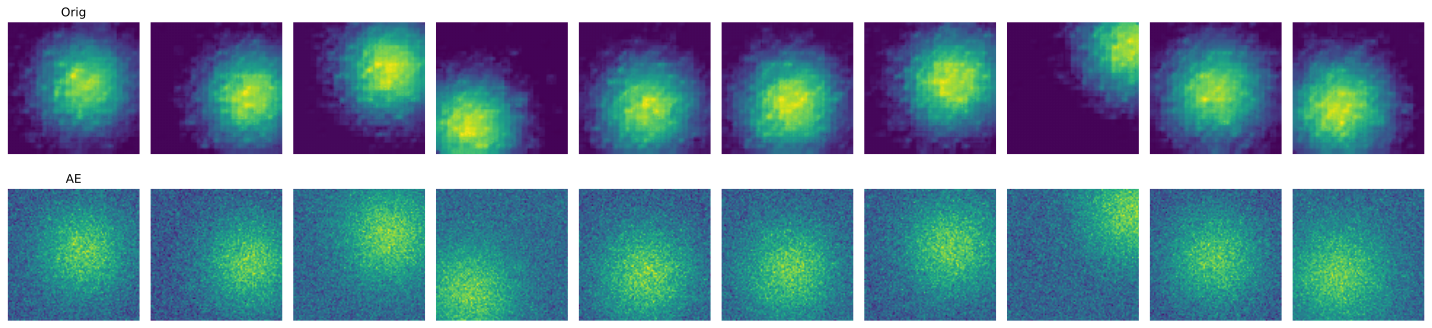

In [102]:
fig, ax = plt.subplots(2, 10, figsize=(20, 5))
for i in range(2):
    for j in range(10):
        if i%2:
            ax[i, j].imshow(torch.permute(images[j], [2, 1, 0]))
            ax[i, j].axis("off")
        else:
            ax[i, j].imshow(torch.permute(ae_images[j], [2, 1, 0]))
            ax[i, j].axis("off")
ax[0, 0].set_title("Orig")
ax[1, 0].set_title("AE")
plt.tight_layout()
plt.show()

In [103]:
images[0]

tensor([[[-0.5283, -0.1294,  0.0087,  ..., -0.0215,  0.0633, -0.0960],
         [-0.0941, -0.1042, -0.1191,  ..., -0.2447, -0.1077,  0.1166],
         [-0.1321, -0.0358,  0.0582,  ..., -0.1778,  0.1010, -0.1487],
         ...,
         [ 0.2724, -0.1672, -0.1418,  ...,  0.2253,  0.2107,  0.2204],
         [ 0.0927,  0.1825, -0.1191,  ...,  0.2141,  0.0209,  0.1049],
         [-0.1292,  0.2482,  0.2226,  ...,  0.1970,  0.2666,  0.2514]]])

In [104]:
ae_images[0]

tensor([[[0.0817, 0.0839, 0.0850,  ..., 0.0850, 0.0839, 0.0830],
         [0.0834, 0.0838, 0.0876,  ..., 0.0876, 0.0838, 0.0838],
         [0.0836, 0.0877, 0.0895,  ..., 0.0895, 0.0877, 0.0856],
         ...,
         [0.0836, 0.0877, 0.0895,  ..., 0.0895, 0.0877, 0.0856],
         [0.0834, 0.0838, 0.0876,  ..., 0.0876, 0.0838, 0.0838],
         [0.0816, 0.0835, 0.0842,  ..., 0.0842, 0.0835, 0.0823]]])

## Remove Occlusion

In [105]:
images.shape

torch.Size([1000, 1, 91, 91])

In [114]:
def train_model():
    net, lossfunc, optimizer = create_model()
    epochs = 50
    batch_size = 16
    losses = []
    for ei in range(epochs):
        batch_loss = []
        net.train()
        for i in range(occ_images.shape[0]//batch_size):
            x = occ_images[i*batch_size:(i+1)*batch_size,:,:,:]
            y = images[i*batch_size:(i+1)*batch_size,:,:,:]
            y_pred = net(x)
            loss = lossfunc(y_pred, y)
            batch_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(np.mean(batch_loss).item())
    return losses, net

        


In [115]:
losses, net = train_model()

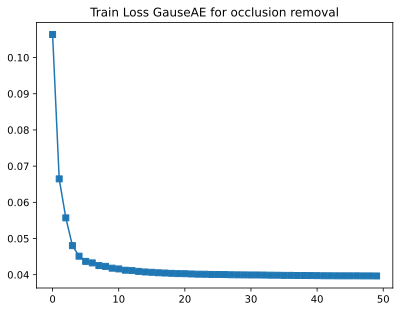

In [116]:
plt.plot(losses, "s-")
plt.title("Train Loss GauseAE for occlusion removal")
plt.show()

In [117]:
net.eval()
with torch.no_grad():
    deocc_images = net(occ_images)
net.train()

GauseAE(
  (enc): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dec): Sequential(
    (0): ConvTranspose2d(4, 6, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(6, 1, kernel_size=(3, 3), stride=(2, 2))
  )
)

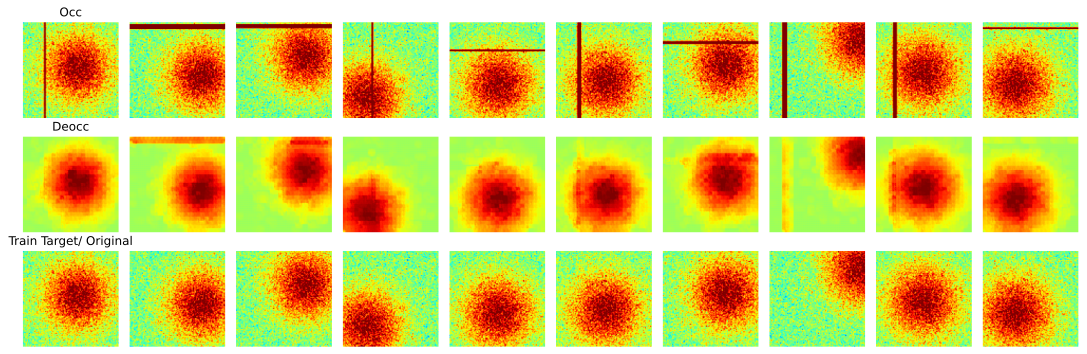

In [138]:
fig, ax = plt.subplots(3, 10, figsize=(15, 5))
for i in range(3):
    for j in range(10):
        if i%4==0:
            ax[i, j].imshow(torch.permute(occ_images[j], [2, 1, 0]), vmax=1, vmin=-1, cmap="jet")
            ax[i, j].axis("off")
        elif i%4==1:
            ax[i, j].imshow(torch.permute(deocc_images[j], [2, 1, 0]), vmax=1, vmin=-1, cmap="jet")
            ax[i, j].axis("off")
        else:
            ax[i, j].imshow(torch.permute(images[j], [2, 1, 0]), vmax=1, vmin=-1, cmap="jet")
            ax[i, j].axis("off")
ax[0, 0].set_title("Occ")
ax[1, 0].set_title("Deocc")
ax[2, 0].set_title("Train Target/ Original")
plt.tight_layout()
plt.show()

In [137]:
from torchsummary import summary
summary(net, (1, 91, 91), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
              ReLU-2            [-1, 6, 91, 91]               0
         MaxPool2d-3            [-1, 6, 45, 45]               0
            Conv2d-4            [-1, 4, 45, 45]             220
              ReLU-5            [-1, 4, 45, 45]               0
         MaxPool2d-6            [-1, 4, 22, 22]               0
   ConvTranspose2d-7            [-1, 6, 45, 45]             222
              ReLU-8            [-1, 6, 45, 45]               0
   ConvTranspose2d-9            [-1, 1, 91, 91]              55
Total params: 557
Trainable params: 557
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.24
Params size (MB): 0.00
Estimated Total Size (MB): 1.27
---------------------------------------------------